In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
s3_path = 's3://energy-forecasting-data/final_energy_features.csv'

df = pd.read_csv(s3_path)

In [3]:
df.head()

,datetime,daily_kwh,avg_voltage,avg_intensity,kitchen_kwh,laundry_kwh,other_kwh,day_of_week,month,is_weekend,rolling_3day_avg,lag_1,is_holiday
0,2006-12-18,36.730433,241.231694,6.421667,1063.0,2621.0,14018.0,0,12,0,37.797011,56.507667,0
1,2006-12-19,27.769900,241.999313,4.926389,839.0,7602.0,6197.0,1,12,0,40.336000,36.730433,0
2,2006-12-20,37.095800,242.308063,6.467361,0.0,2648.0,14063.0,2,12,0,33.865378,27.769900,0
3,2006-12-21,28.610400,241.040549,5.033797,1765.0,2623.0,10421.0,3,12,0,31.158700,37.095800,0
4,2006-12-22,39.022300,241.184549,6.872917,3151.0,350.0,11131.0,4,12,0,34.909500,28.610400,0


In [4]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431 entries, 0 to 1430
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetime          1431 non-null   object 
 1   daily_kwh         1431 non-null   float64
 2   avg_voltage       1431 non-null   float64
 3   avg_intensity     1431 non-null   float64
 4   kitchen_kwh       1431 non-null   float64
 5   laundry_kwh       1431 non-null   float64
 6   other_kwh         1431 non-null   float64
 7   day_of_week       1431 non-null   int64  
 8   month             1431 non-null   int64  
 9   is_weekend        1431 non-null   int64  
 10  rolling_3day_avg  1431 non-null   float64
 11  lag_1             1431 non-null   float64
 12  is_holiday        1431 non-null   int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 145.5+ KB


datetime            0
daily_kwh           0
avg_voltage         0
avg_intensity       0
kitchen_kwh         0
laundry_kwh         0
other_kwh           0
day_of_week         0
month               0
is_weekend          0
rolling_3day_avg    0
lag_1               0
is_holiday          0
dtype: int64

In [5]:
df_raw = df.copy()

In [6]:
df_raw['datetime'] = pd.to_datetime(df_raw['datetime'])

In [7]:
df_raw['datetime'].head()

0   2006-12-18
1   2006-12-19
2   2006-12-20
3   2006-12-21
4   2006-12-22
Name: datetime, dtype: datetime64[ns]

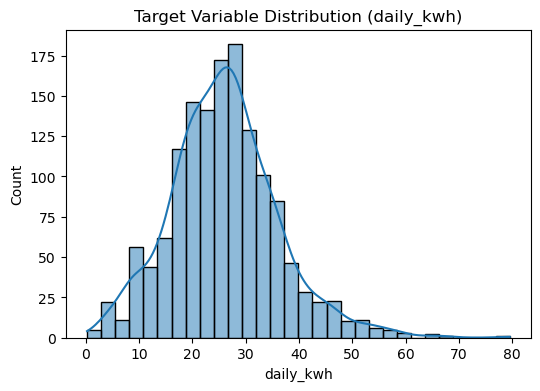

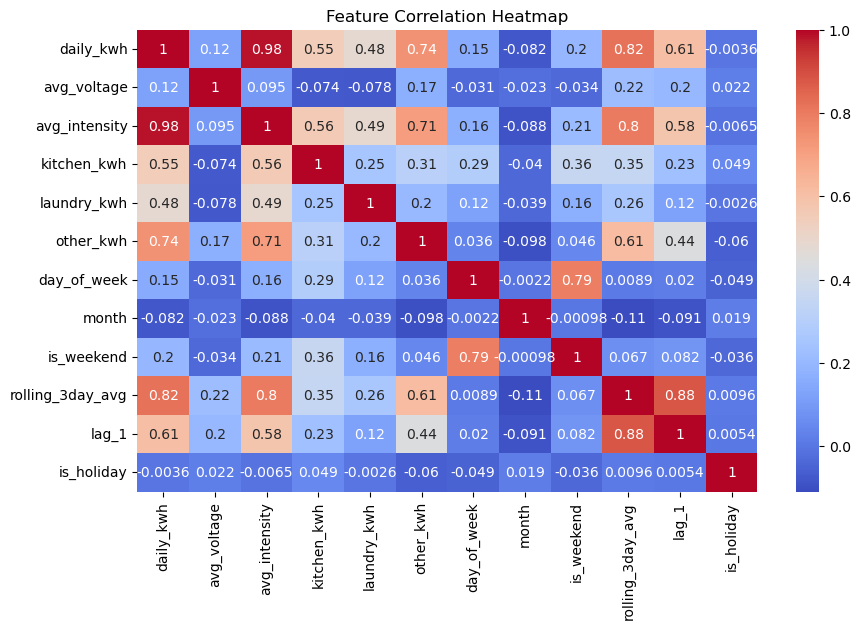

In [8]:
plt.figure(figsize=(6, 4))
sns.histplot(df_raw['daily_kwh'], bins=30, kde=True)
plt.title('Target Variable Distribution (daily_kwh)')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(df_raw.drop(columns='datetime').corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

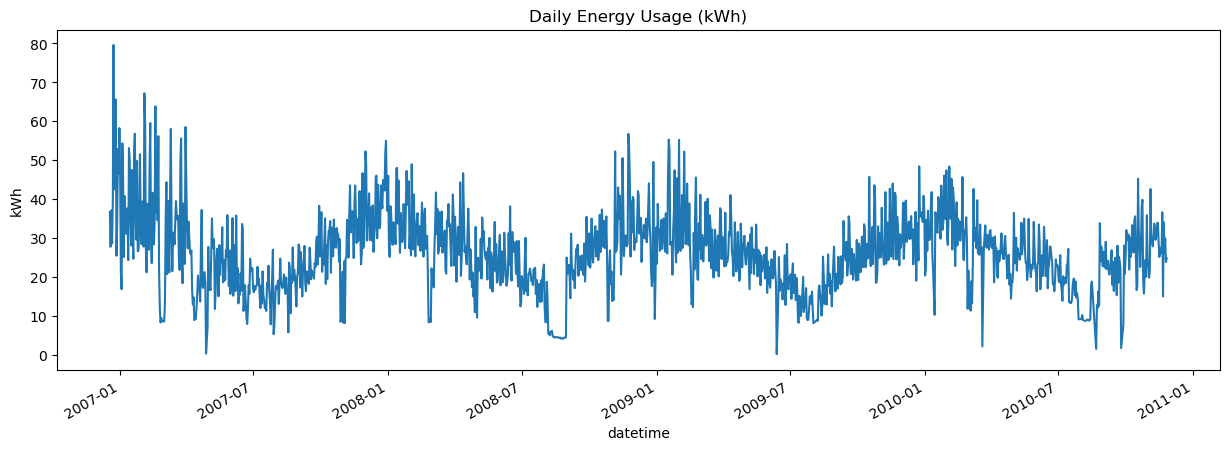

In [9]:
df_raw['datetime'] = pd.to_datetime(df_raw['datetime'])
df_raw.set_index('datetime', inplace=True)

df_raw['daily_kwh'].plot(figsize=(15, 5), title='Daily Energy Usage (kWh)')
plt.ylabel('kWh')
plt.show()

In [10]:
df_raw.drop(columns='avg_intensity', inplace=True)

In [11]:
df_raw.drop(columns=['rolling_3day_avg'])

,daily_kwh,avg_voltage,kitchen_kwh,laundry_kwh,other_kwh,day_of_week,month,is_weekend,lag_1,is_holiday
datetime,,,,,,,,,,
2006-12-18,36.730433,241.231694,1063.0,2621.0,14018.0,0,12,0,56.507667,0
2006-12-19,27.769900,241.999313,839.0,7602.0,6197.0,1,12,0,36.730433,0
2006-12-20,37.095800,242.308063,0.0,2648.0,14063.0,2,12,0,27.769900,0
2006-12-21,28.610400,241.040549,1765.0,2623.0,10421.0,3,12,0,37.095800,0
2006-12-22,39.022300,241.184549,3151.0,350.0,11131.0,4,12,0,28.610400,0
...,...,...,...,...,...,...,...,...,...,...
2010-11-22,34.025600,240.197118,4855.0,2110.0,10136.0,0,11,0,15.015167,0
2010-11-23,26.292267,240.575528,1871.0,458.0,7611.0,1,11,0,34.025600,0
2010-11-24,29.937467,240.030965,1096.0,2848.0,12224.0,2,11,0,26.292267,0


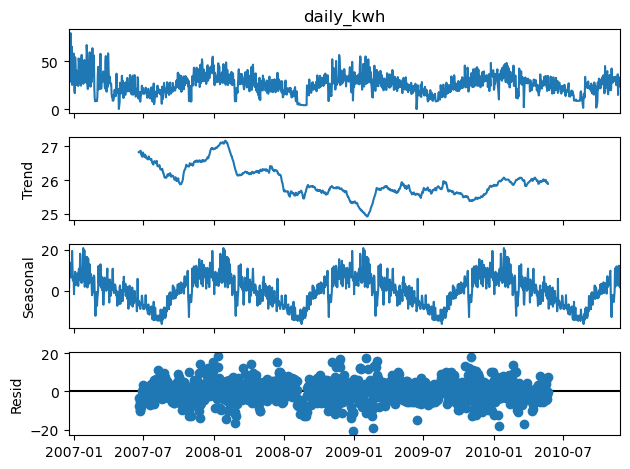

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_raw['daily_kwh'], model='additive', period=365)
result.plot()
plt.tight_layout()
plt.show()

In [13]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['daily_kwh'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -3.731891384149644
p-value: 0.0036862909384920606


In [14]:
df_ts = df_raw[['daily_kwh']].copy()
df_ts.head()

,daily_kwh
datetime,
2006-12-18,36.730433
2006-12-19,27.769900
2006-12-20,37.095800
2006-12-21,28.610400
2006-12-22,39.022300


In [94]:
sarima_model_weekly = auto_arima(
    df_ts['daily_kwh'],
    start_p=1, start_q=1,
    max_p=2, max_q=2,
    start_P=0, start_Q=0,
    max_P=1, max_Q=1,
    seasonal=True,
    m=7,  # weekly seasonality
    d=1, D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=10902.542, Time=0.05 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[7]             : AIC=10364.582, Time=0.27 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[7]             : AIC=9705.927, Time=0.41 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=10538.792, Time=0.12 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,1)[7]             : AIC=9707.446, Time=0.58 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,0)[7]             : AIC=10138.585, Time=0.24 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,1)[7]             : AIC=10160.500, Time=0.21 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,1)[7]             : AIC=9666.204, Time=0.53 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,1)[7]             : AIC=9667.562, Time=1.00 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,0)[7]             : AIC=inf, Time=1.73 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,1)[7]             : AIC=9971.420, Time=0.39 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,1)[7]             : AIC=9666.158, Time=0.94 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,0)[7]             : AIC=inf, Time=1.32 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,1)[7]             : AIC=9668.106, Time=1.32 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,0)[7]             : AIC=inf, Time=2.36 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,1)[7]             : AIC=9786.939, Time=0.71 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,1,1)[7]             : AIC=9664.774, Time=1.84 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,1,0)[7]             : AIC=inf, Time=1.61 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,1,1)[7]             : AIC=9666.751, Time=2.11 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,1,0)[7]             : AIC=inf, Time=2.99 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,1)[7]             : AIC=9662.781, Time=1.40 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,0)[7]             : AIC=inf, Time=0.99 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,1)[7]             : AIC=9664.768, Time=1.91 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,0)[7]             : AIC=inf, Time=2.55 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,1)[7]             : AIC=9661.609, Time=0.55 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,0)[7]             : AIC=inf, Time=0.97 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,1)[7]             : AIC=9663.481, Time=0.91 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,0)[7]             : AIC=inf, Time=1.17 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,1)[7] intercept   : AIC=9663.540, Time=2.66 sec

Best model:  ARIMA(0,1,2)(0,1,1)[7]          
Total fit time: 34.729 seconds


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1431
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -4826.804
Date:                             Tue, 22 Jul 2025   AIC                           9661.609
Time:                                     15:50:00   BIC                           9682.651
Sample:                                          0   HQIC                          9669.468
                                            - 1431                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6138      0.020    -30.058      0.000      -0.654      -0.574
ma.L2         -0.2060      

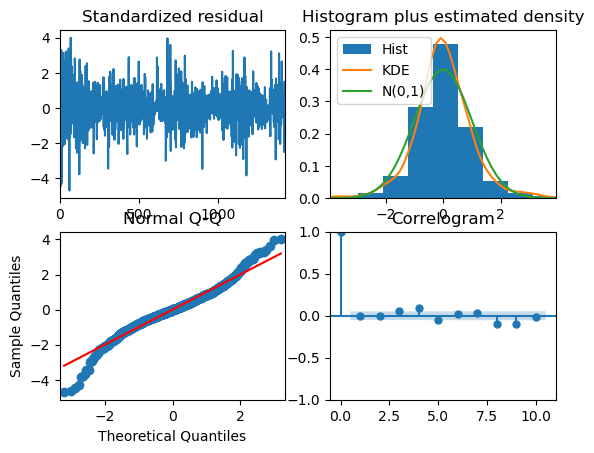

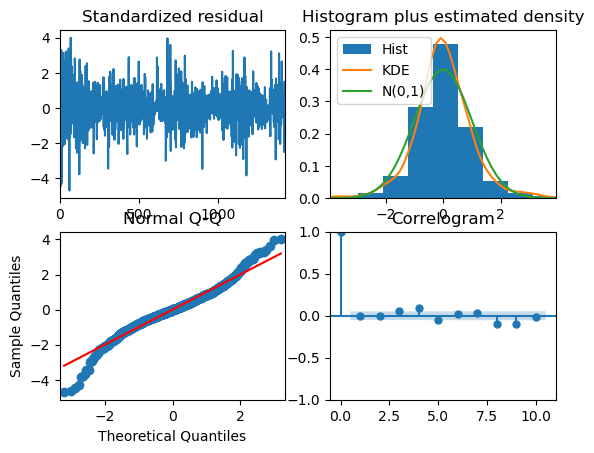

In [96]:
print(sarima_model_weekly.summary())
sarima_model_weekly.plot_diagnostics()

In [97]:
n_days = 365 
forecast, conf_int = sarima_model_weekly.predict(n_periods=n_days, return_conf_int=True)

/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


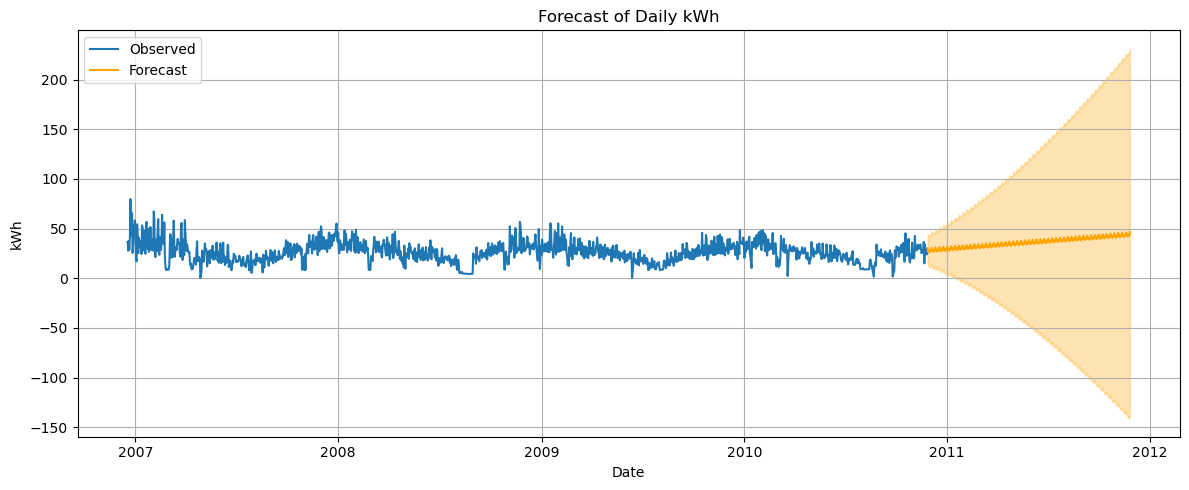

In [98]:
future_dates = pd.date_range(start=df_ts.index[-1] + pd.Timedelta(days=1), periods=n_days)

plt.figure(figsize=(12, 5))
plt.plot(df_ts.index, df_ts['daily_kwh'], label='Observed')
plt.plot(future_dates, forecast, label='Forecast', color='orange')
plt.fill_between(future_dates, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.3)
plt.title('Forecast of Daily kWh')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [99]:
monthly_kwh = df_ts['daily_kwh'].resample('ME').mean()

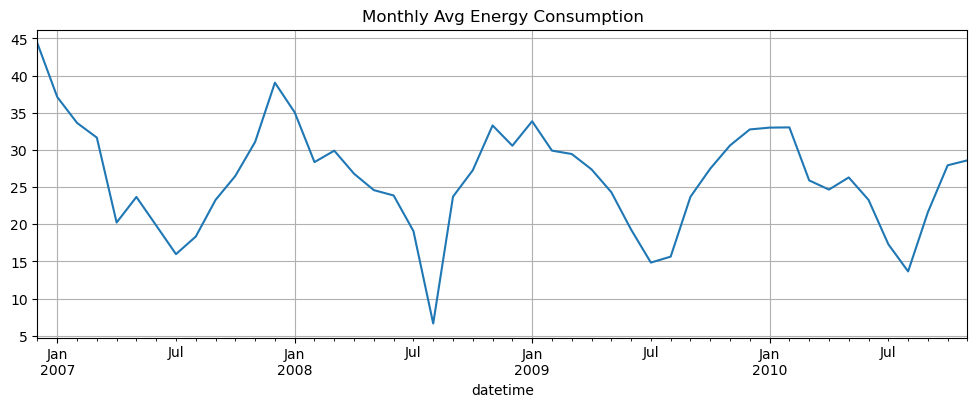

In [100]:
monthly_kwh.plot(figsize=(12, 4), title='Monthly Avg Energy Consumption')
plt.grid(True)
plt.show()

In [101]:
sarima_model_monthly = auto_arima(
    monthly_kwh,
    seasonal=True,
    m=12,                  # 12 months = yearly seasonality
    start_p=1, start_q=1,
    max_p=2, max_q=2,
    start_P=0, start_Q=0,
    max_P=1, max_Q=1,
    d=1, D=1,
    trace=True,
    stepwise=True,
    error_action='ignore',
    suppress_warnings=True
)

/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=223.015, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=211.392, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=218.147, Time=0.02 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.17 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,0)[12]             : AIC=216.350, Time=0.04 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=209.118, Time=0.06 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=215.842, Time=0.03 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,1)[12]             : AIC=210.110, Time=0.15 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=0.25 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,0)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=202.517, Time=0.06 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=202.226, Time=0.07 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,1)[12]             : AIC=inf, Time=0.26 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.08 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.16 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,1,1)[12]             : AIC=inf, Time=0.36 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.25 sec

Best model:  ARIMA(1,1,1)(0,1,1)[12]          
Total fit time: 3.477 seconds


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -97.113
Date:                            Tue, 22 Jul 2025   AIC                            202.226
Time:                                    15:50:46   BIC                            208.447
Sample:                                12-31-2006   HQIC                           204.373
                                     - 11-30-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0013      0.350      0.004      0.997      -0.685       0.688
ma.L1         -0.9886      1.723   

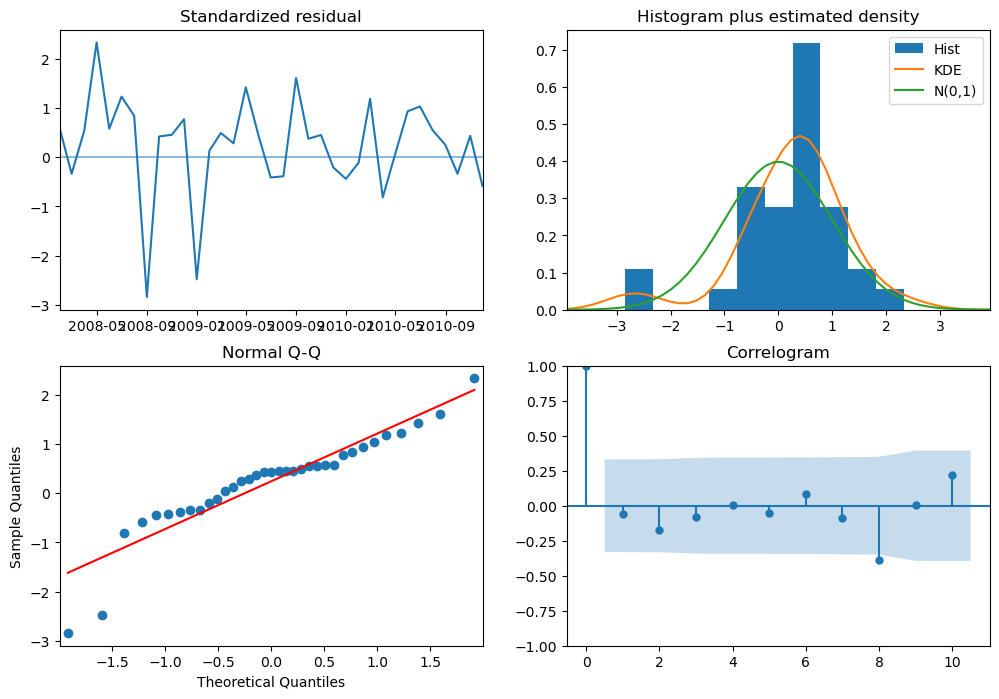

In [102]:
print(sarima_model_monthly.summary())
sarima_model_monthly.plot_diagnostics(figsize=(12, 8))
plt.show()

In [103]:
n_periods = 12
forecast, conf_int = sarima_model_monthly.predict(n_periods=n_periods, return_conf_int=True)

/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [104]:
forecast_index = pd.date_range(
    start=monthly_kwh.index[-1] + pd.DateOffset(months=1),
    periods=n_periods,
    freq='ME' 
)

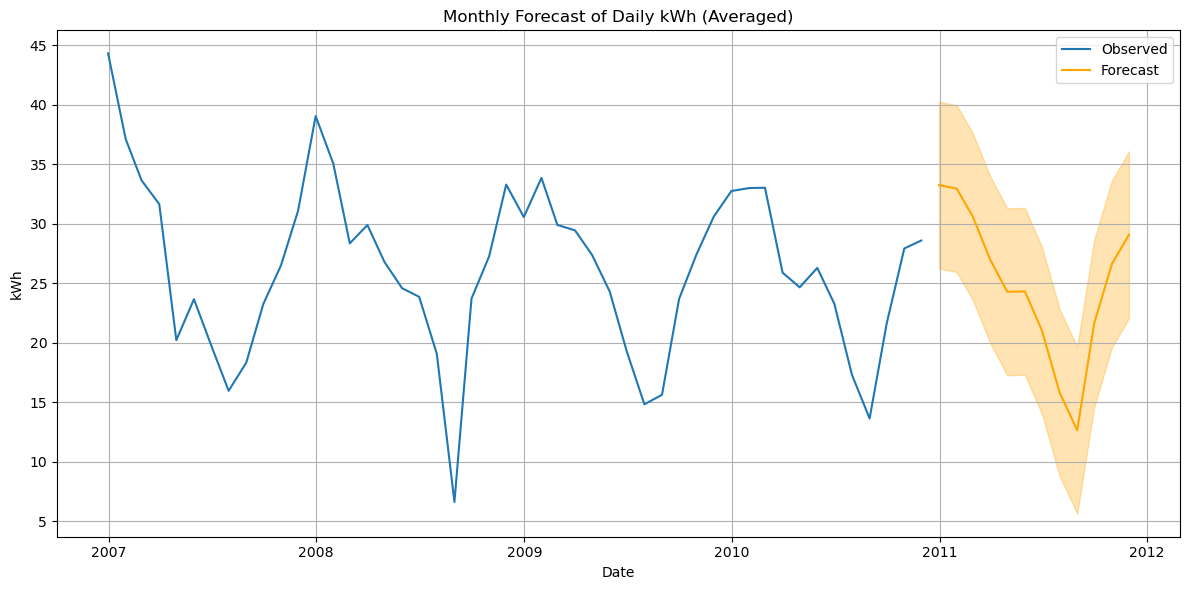

In [105]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_kwh, label='Observed')
plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], 
                 color='orange', alpha=0.3)

plt.title('Monthly Forecast of Daily kWh (Averaged)')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [106]:
forecast_index = monthly_kwh.index[-1] + pd.offsets.MonthBegin(1)
forecast_dates = pd.date_range(start=forecast_index, periods=n_periods, freq='MS')

df_monthly_forecast = pd.DataFrame({
    'forecast_date': forecast_dates,
    'forecast_kwh': forecast,
    'lower_bound': conf_int[:, 0],
    'upper_bound': conf_int[:, 1]
})

In [107]:
df_monthly_forecast.to_csv('monthly_sarima_forecast.csv', index=False)

In [108]:
df_raw['month_sin'] = np.sin(2 * np.pi * df_raw['month'] / 12)
df_raw['month_cos'] = np.cos(2 * np.pi * df_raw['month'] / 12)

In [109]:
feature_cols = [
    'rolling_3day_avg',
    'lag_1',
    'other_kwh',
    'kitchen_kwh',
    'laundry_kwh',
    'is_weekend',
    'is_holiday',
    'month_sin',
    'month_cos'
]

In [110]:
X = df_raw[feature_cols]
y = df_raw['daily_kwh']

split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [111]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [113]:
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [114]:
y_pred = xgb_model.predict(X_test)

In [115]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")

RMSE: 2.55
MAE: 1.93
R²: 0.893


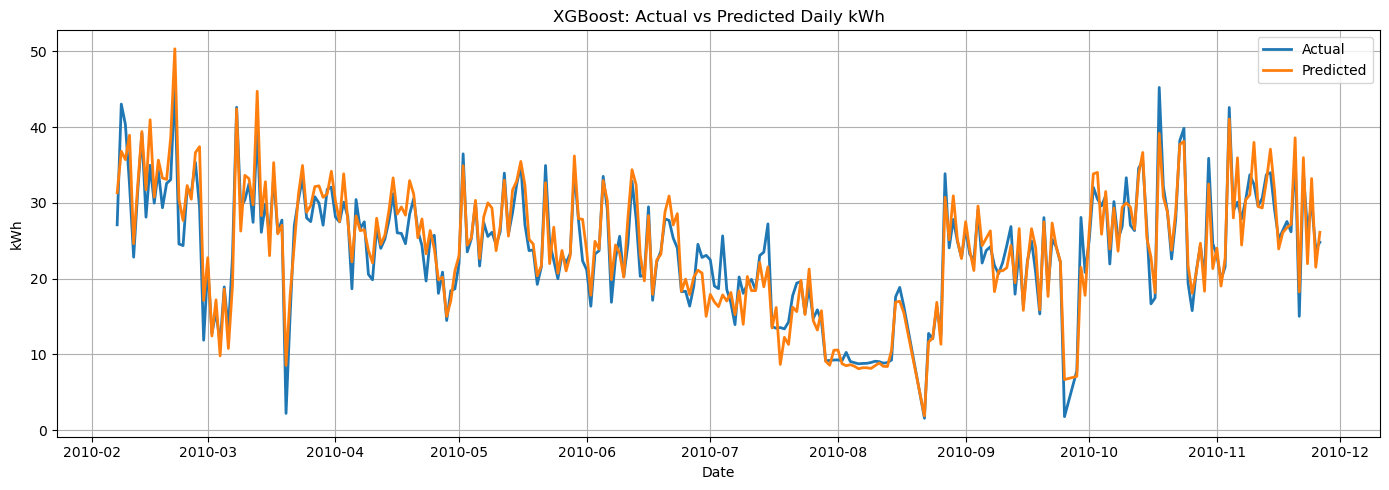

In [116]:
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test.values, label='Actual', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted', linewidth=2)
plt.title('XGBoost: Actual vs Predicted Daily kWh')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_1297/2535461685.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')


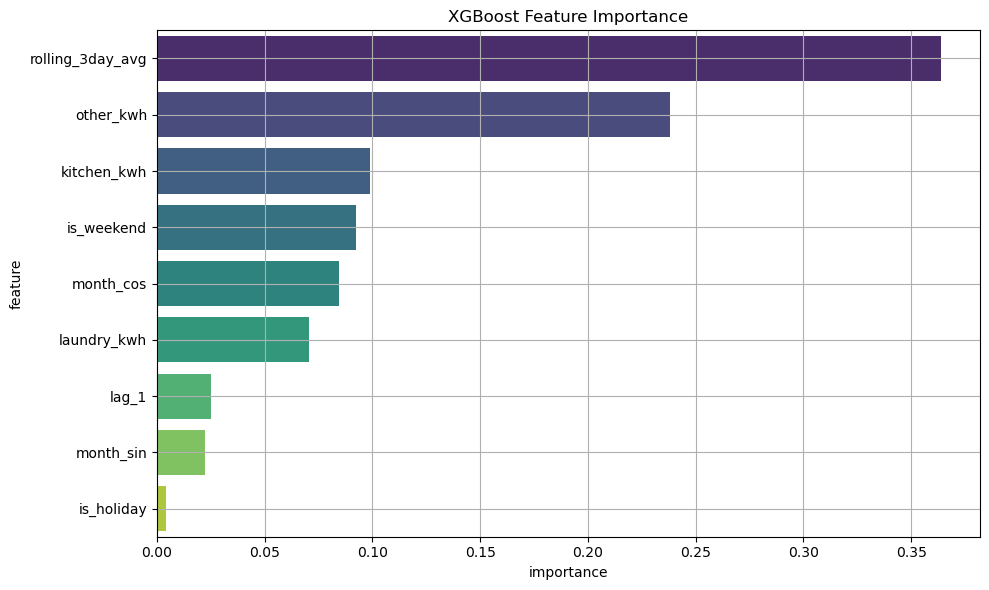

In [117]:
importance_scores = xgb_model.feature_importances_

importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importance_scores
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.grid(True)
plt.show()

In [81]:
print(df_raw.index.max())

2010-11-26 00:00:00


In [146]:
sarima_train = monthly_kwh[:'2009-12-31']

sarima_model_test = auto_arima(
    sarima_train,
    seasonal=True,
    m=12,
    start_p=1, start_q=1,
    max_p=2, max_q=2,
    start_P=0, start_Q=0,
    max_P=1, max_Q=1,
    d=1, D=1,
    trace=True,
    stepwise=True,
    error_action='ignore',
    suppress_warnings=True
)

/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=159.655, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=151.807, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=156.713, Time=0.02 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=153.319, Time=0.03 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,0)[12]             : AIC=151.550, Time=0.07 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=155.345, Time=0.03 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.32 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=0.23 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,0)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=0.20 sec


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,0)[12] intercept   : AIC=153.165, Time=0.10 sec

Best model:  ARIMA(2,1,0)(1,1,0)[12]          
Total fit time: 1.955 seconds


In [186]:
sarima_preds_2010 = sarima_model_test.predict(n_periods=12)
forecast_index_2010 = pd.date_range(
    start=sarima_train.index[-1] + pd.DateOffset(months=1),
    periods=n_periods,
    freq='ME' 
)

/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


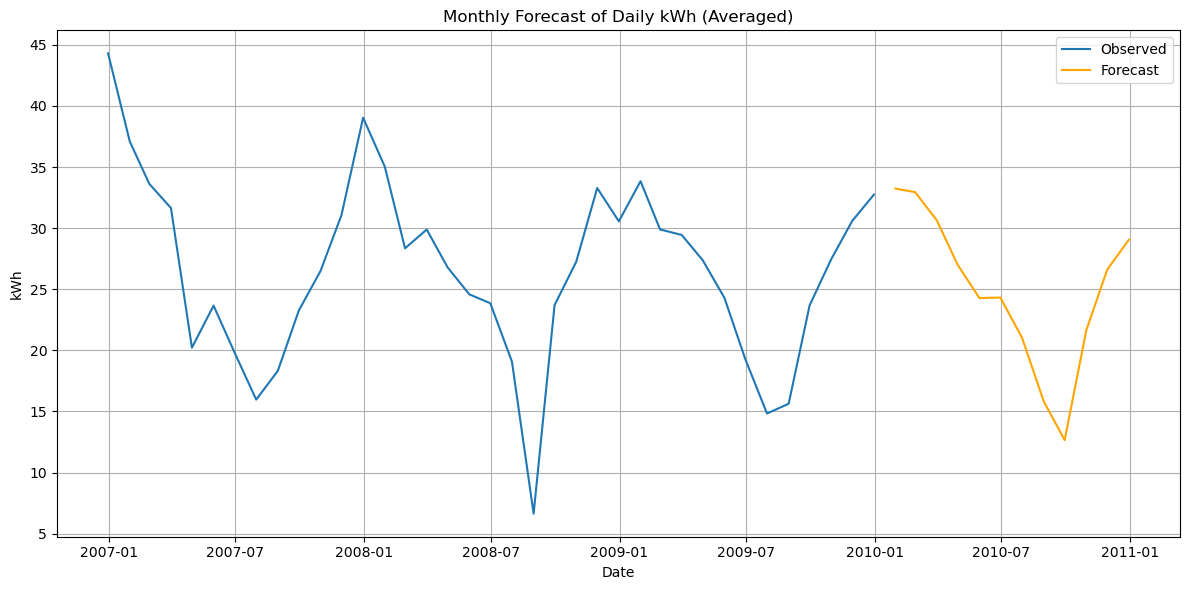

In [187]:
plt.figure(figsize=(12, 6))
plt.plot(sarima_train, label='Observed')
plt.plot(forecast_index_2010, forecast, label='Forecast', color='orange')

plt.title('Monthly Forecast of Daily kWh (Averaged)')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [188]:
actual_2010 = monthly_kwh['2010-01-31':'2010-12-31']
print(actual_2010)

datetime
2010-01-31    32.988699
2010-02-28    33.018873
2010-03-31    25.890268
2010-04-30    24.654513
2010-05-31    26.286237
2010-06-30    23.269680
2010-07-31    17.305243
2010-08-31    13.644058
2010-09-30    21.612752
2010-10-31    27.920943
2010-11-30    28.588710
Freq: ME, Name: daily_kwh, dtype: float64


In [189]:
sarima_preds_2010

2010-01-31    33.116730
2010-02-28    27.253253
2010-03-31    27.694134
2010-04-30    25.252952
2010-05-31    22.661635
2010-06-30    20.136513
2010-07-31    15.531581
2010-08-31     8.457316
2010-09-30    21.858112
2010-10-31    25.511169
2010-11-30    30.360940
2010-12-31    29.610714
Freq: ME, dtype: float64

In [190]:
xgb_results = pd.DataFrame({
    'date': X_test.index,
    'actual_kwh': y_test.values,
    'xgb_pred': y_pred
})

xgb_results['month'] = xgb_results['date'].dt.to_period('M').dt.to_timestamp()

xgb_monthly_2010 = xgb_results[
    (xgb_results['date'] >= '2010-01-01') &
    (xgb_results['date'] <= '2010-11-30')  # full Nov
].groupby('month')[['actual_kwh', 'xgb_pred']].sum().reset_index()

print(xgb_monthly_2010)

       month  actual_kwh    xgb_pred
0 2010-02-01  693.155567  745.573792
1 2010-03-01  802.598300  828.562683
2 2010-04-01  739.635400  779.147278
3 2010-05-01  814.873333  843.302063
4 2010-06-01  698.090400  719.086914
5 2010-07-01  536.462533  492.949921
6 2010-08-01  368.389567  359.856110
7 2010-09-01  605.157067  606.369873
8 2010-10-01  865.549233  864.755981
9 2010-11-01  743.306467  754.381104


In [191]:
xgb_results.head()

,date,actual_kwh,xgb_pred,month
0,2010-02-07,27.095133,31.327993,2010-02-01
1,2010-02-08,43.037300,36.807117,2010-02-01
2,2010-02-09,40.348867,35.714157,2010-02-01
3,2010-02-10,32.409033,38.925983,2010-02-01
4,2010-02-11,22.829467,24.605320,2010-02-01


In [192]:
xgb_monthly_2010['xgb_pred'] = xgb_monthly_2010['xgb_pred'] / xgb_monthly_2010['month'].dt.days_in_month
xgb_monthly_2010['actual_kwh'] = xgb_monthly_2010['actual_kwh'] / xgb_monthly_2010['month'].dt.days_in_month
xgb_monthly_2010.set_index('month', inplace=True)

In [193]:
xgb_monthly_2010.head()

,actual_kwh,xgb_pred
month,,
2010-02-01,24.755556,26.627635
2010-03-01,25.890268,26.727828
2010-04-01,24.654513,25.971576
2010-05-01,26.286237,27.203292
2010-06-01,23.269680,23.969564


In [194]:
print(X_test.index.min(), X_test.index.max())

2010-02-07 00:00:00 2010-11-26 00:00:00


In [195]:
print("Length of actual_2010:", len(actual_2010.values))
print("Length of sarima_preds_2010:", len(sarima_preds_2010))
print("Length of xgb_monthly_2010:", len(xgb_monthly_2010))

Length of actual_2010: 11
Length of sarima_preds_2010: 12
Length of xgb_monthly_2010: 10


In [196]:
print(sarima_preds_2010.index[0], sarima_preds_2010.index[-1])
print(actual_2010.index[0], actual_2010.index[-1])
print(xgb_monthly_2010.index[0], xgb_monthly_2010.index[-1])

2010-01-31 00:00:00 2010-12-31 00:00:00
2010-01-31 00:00:00 2010-11-30 00:00:00
2010-02-01 00:00:00 2010-11-01 00:00:00


In [201]:
sarima_2010 = sarima_preds_2010[1:-1].copy()       # Feb to Nov
actual_10 = actual_2010[1:].copy()                     # Feb to Nov

In [202]:
print("Length of actual_2010:", len(actual_10.values))
print("Length of sarima_preds_2010:", len(sarima_2010))
print("Length of xgb_monthly_2010:", len(xgb_monthly_2010))

Length of actual_2010: 10
Length of sarima_preds_2010: 10
Length of xgb_monthly_2010: 10


In [203]:
sarima_2010.index

DatetimeIndex(['2010-02-28', '2010-03-31', '2010-04-30', '2010-05-31',
               '2010-06-30', '2010-07-31', '2010-08-31', '2010-09-30',
               '2010-10-31', '2010-11-30'],
              dtype='datetime64[ns]', freq='ME')

In [204]:
comparison_df = pd.DataFrame({
    'month': sarima_2010.index,
    'actual_kwh': actual_10.values,
    'sarima_pred': sarima_2010,
    'xgb_pred': xgb_monthly_2010['xgb_pred'].values
})

In [205]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

for model in ['sarima_pred', 'xgb_pred']:
    rmse = mean_squared_error(comparison_df['actual_kwh'], comparison_df[model])
    mae = mean_absolute_error(comparison_df['actual_kwh'], comparison_df[model])
    r2 = r2_score(comparison_df['actual_kwh'], comparison_df[model])
    print(f"\n{model}:\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.3f}")


sarima_pred:
RMSE: 9.89, MAE: 2.63, R2: 0.653

xgb_pred:
RMSE: 6.45, MAE: 1.85, R2: 0.773


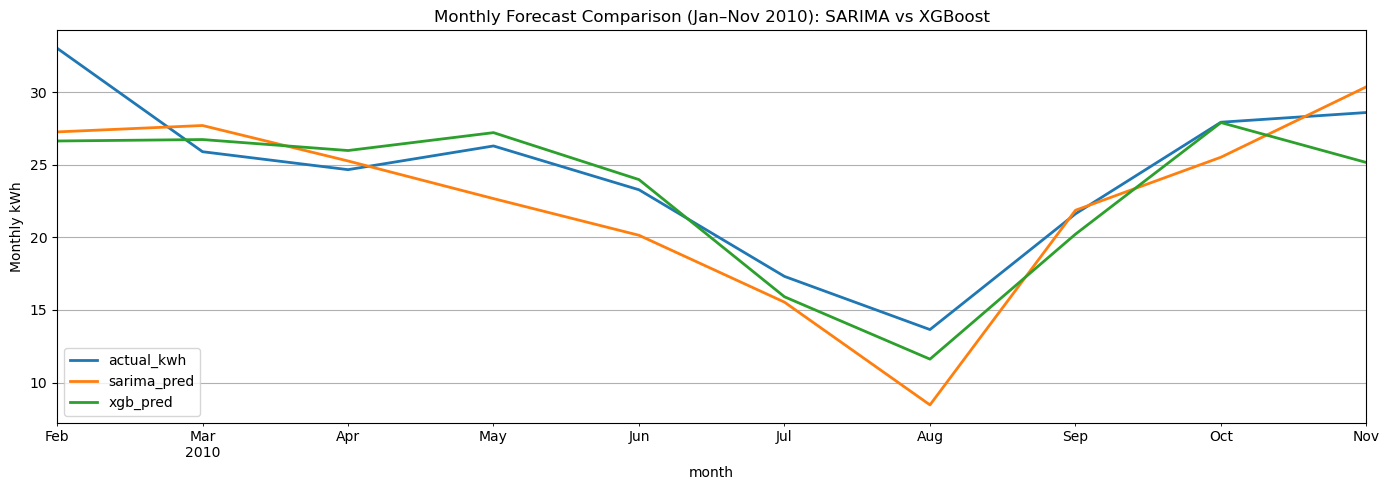

In [206]:
comparison_df.set_index('month')[['actual_kwh', 'sarima_pred', 'xgb_pred']].plot(figsize=(14, 5), linewidth=2)
plt.title("Monthly Forecast Comparison (Jan–Nov 2010): SARIMA vs XGBoost")
plt.ylabel("Monthly kWh")
plt.grid(True)
plt.tight_layout()
plt.show()

In [207]:
comparison_df.to_csv("comparison_predictions.csv", index=False)

## Cumulative Energy Difference Plot

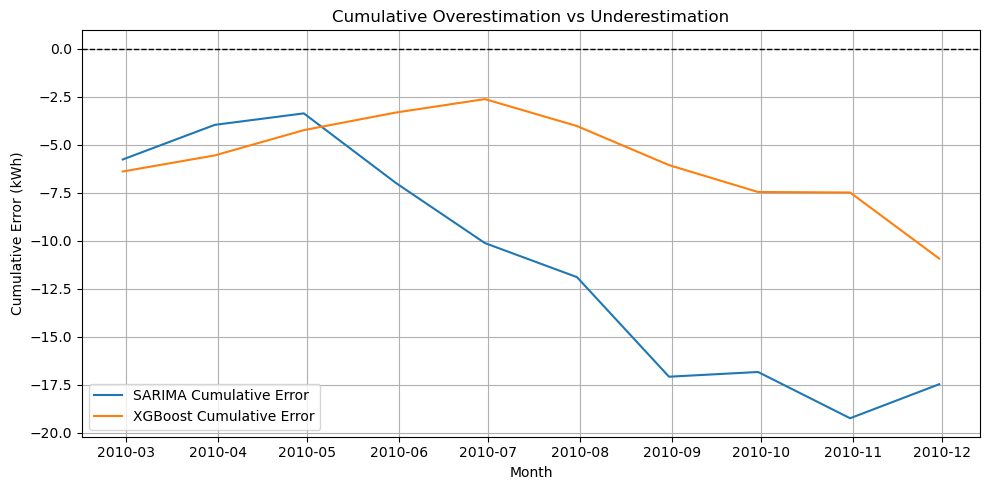

In [208]:
comparison_df['sarima_diff'] = comparison_df['sarima_pred'] - comparison_df['actual_kwh']
comparison_df['xgb_diff'] = comparison_df['xgb_pred'] - comparison_df['actual_kwh']

comparison_df['sarima_cumdiff'] = comparison_df['sarima_diff'].cumsum()
comparison_df['xgb_cumdiff'] = comparison_df['xgb_diff'].cumsum()

plt.figure(figsize=(10, 5))
plt.plot(comparison_df['month'], comparison_df['sarima_cumdiff'], label='SARIMA Cumulative Error')
plt.plot(comparison_df['month'], comparison_df['xgb_cumdiff'], label='XGBoost Cumulative Error')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Cumulative Overestimation vs Underestimation")
plt.xlabel("Month")
plt.ylabel("Cumulative Error (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Error by Month (Bar Plot)

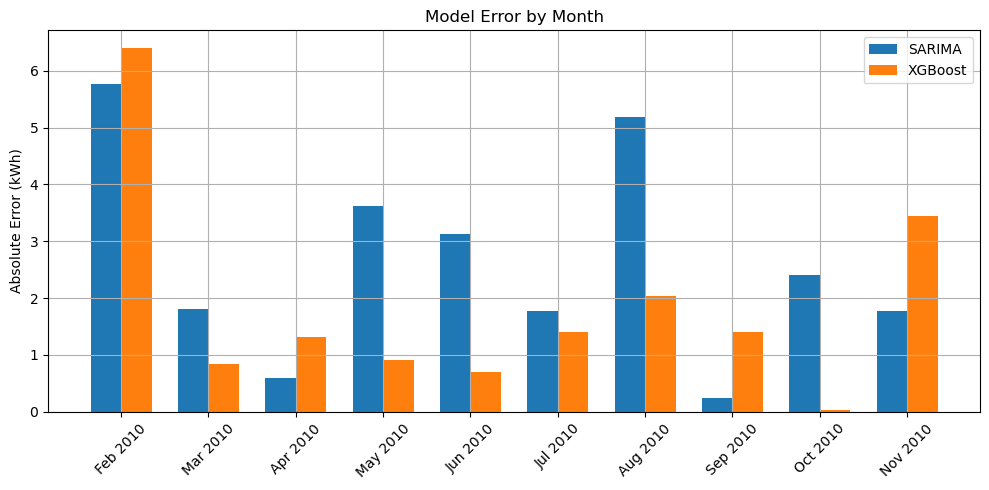

In [226]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

comparison_df['sarima_abs_error'] = abs(comparison_df['sarima_pred'] - comparison_df['actual_kwh'])
comparison_df['xgb_abs_error'] = abs(comparison_df['xgb_pred'] - comparison_df['actual_kwh'])

plt.figure(figsize=(10, 5))
width = 0.35
months = comparison_df['month'].dt.strftime('%b %Y')
x = np.arange(len(months))

plt.bar(x - width/2, comparison_df['sarima_abs_error'], width, label='SARIMA')
plt.bar(x + width/2, comparison_df['xgb_abs_error'], width, label='XGBoost')

plt.xticks(x, months, rotation=45)
plt.ylabel('Absolute Error (kWh)')
plt.title('Model Error by Month')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

### Monthly Model Performance Insights

| **Month**    | **Key Insight**                                      |
|--------------|-------------------------------------------------------|
| Mar–May      | Both models perform well with low forecasting error. |
| Jun–Aug      | SARIMA struggles more than XGBoost (underpredicts).  |
| Oct–Nov      | XGBoost underperforms SARIMA slightly.               |

In [216]:
import boto3

s3 = boto3.client('s3')
bucket_name = 'energy-forecasting-data'

files_to_upload = {
    'xgboost_daily_forecast.csv': 'energy/xgboost_daily_forecast.csv',
    'monthly_sarima_forecast.csv': 'energy/monthly_sarima_forecast.csv',
    'comparison_predictions.csv': 'energy/comparison_predictions.csv'
}

for local_file, s3_path in files_to_upload.items():
    s3.upload_file(local_file, bucket_name, s3_path)
    print(f"Uploaded {local_file} to s3://{bucket_name}/{s3_path}")

Uploaded xgboost_daily_forecast.csv to s3://energy-forecasting-data/energy/xgboost_daily_forecast.csv
Uploaded monthly_sarima_forecast.csv to s3://energy-forecasting-data/energy/monthly_sarima_forecast.csv
Uploaded comparison_predictions.csv to s3://energy-forecasting-data/energy/comparison_predictions.csv


In [236]:
df_sarima = pd.read_csv("monthly_sarima_forecast.csv")
df_xgb = pd.read_csv("xgboost_daily_forecast.csv")
df_comp = pd.read_csv("comparison_predictions.csv")

In [237]:
df_comp.dtypes

month           object
actual_kwh     float64
sarima_pred    float64
xgb_pred       float64
dtype: object

In [238]:
df_xgb.dtypes

date                  object
actual_kwh           float64
xgb_predicted_kwh    float64
dtype: object

In [239]:
df_sarima.dtypes

forecast_date     object
forecast_kwh     float64
lower_bound      float64
upper_bound      float64
dtype: object

In [240]:
df_comp['month'].unique()

array(['2010-02-28', '2010-03-31', '2010-04-30', '2010-05-31',
       '2010-06-30', '2010-07-31', '2010-08-31', '2010-09-30',
       '2010-10-31', '2010-11-30'], dtype=object)

In [244]:
df_comp['month'] = pd.to_datetime(df_comp['month'])
df_comp['month'] = df_comp['month'].dt.to_period('M').dt.to_timestamp()

In [245]:
df_comp.dtypes

month          datetime64[ns]
actual_kwh            float64
sarima_pred           float64
xgb_pred              float64
dtype: object

In [246]:
df_comp.head()

,month,actual_kwh,sarima_pred,xgb_pred
0,2010-02-01,33.018873,27.253253,26.627635
1,2010-03-01,25.890268,27.694134,26.727828
2,2010-04-01,24.654513,25.252952,25.971576
3,2010-05-01,26.286237,22.661635,27.203292
4,2010-06-01,23.269680,20.136513,23.969564


In [247]:
df_xgb['date'] = pd.to_datetime(df_xgb['date'])
df_xgb.head()

,date,actual_kwh,xgb_predicted_kwh
0,2010-02-07,27.095133,31.327993
1,2010-02-08,43.037300,36.807117
2,2010-02-09,40.348867,35.714157
3,2010-02-10,32.409033,38.925983
4,2010-02-11,22.829467,24.605320


In [253]:
df_sarima['forecast_date'] = pd.to_datetime(df_sarima['forecast_date'])
df_sarima['forecast_date'] = df_sarima['forecast_date'].dt.to_period('M').dt.to_timestamp()
df_sarima = df_sarima.drop(columns=["month"])
df_sarima.head()

,forecast_date,forecast_kwh,lower_bound,upper_bound
0,2010-12-01,33.236067,26.234752,40.237382
1,2011-01-01,32.946242,25.944059,39.948424
2,2011-02-01,30.643538,23.640914,37.646162
3,2011-03-01,26.984146,19.981080,33.987211
4,2011-04-01,24.282055,17.278548,31.285562


In [254]:
import boto3

s3 = boto3.client('s3')
bucket_name = 'energy-forecasting-data'

files_to_upload = {
    'xgboost_daily_forecast.csv': 'energy/xgboost_daily_forecast.csv',
    'monthly_sarima_forecast.csv': 'energy/monthly_sarima_forecast.csv',
    'comparison_predictions.csv': 'energy/comparison_predictions.csv'
}

for local_file, s3_path in files_to_upload.items():
    s3.upload_file(local_file, bucket_name, s3_path)
    print(f"Uploaded {local_file} to s3://{bucket_name}/{s3_path}")

Uploaded xgboost_daily_forecast.csv to s3://energy-forecasting-data/energy/xgboost_daily_forecast.csv
Uploaded monthly_sarima_forecast.csv to s3://energy-forecasting-data/energy/monthly_sarima_forecast.csv
Uploaded comparison_predictions.csv to s3://energy-forecasting-data/energy/comparison_predictions.csv
